<a href="https://colab.research.google.com/github/leahmcgovern/temp/blob/main/Random_Forest_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [ ]:
def run_random_forest(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_col: str,
    model_name: str,
    price_spike_threshold: float = 150
):
    # Split features and target

    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    # Safety check: column alignment
    assert list(X_train.columns) == list(X_test.columns), \
        "Train/Test feature mismatch!"


    # Random Forest model

    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=18,
        min_samples_leaf=25,
        max_features="sqrt",   # reduces correlation between trees
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # -----------------------------
    # Regression metrics
    # -----------------------------
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n===== {model_name} =====")
    print(f"MAE  : £{mae:.2f}")
    print(f"RMSE : £{rmse:.2f}")
    print(f"R²   : {r2:.3f}")
    print(f"OOB R²: {rf.oob_score_:.3f}")

    # -----------------------------
    # Stress-event diagnostics
    # -----------------------------
    is_stress = y_test > price_spike_threshold

    mae_normal = mean_absolute_error(y_test[~is_stress], y_pred[~is_stress])
    mae_stress = mean_absolute_error(y_test[is_stress], y_pred[is_stress])

    print("\n--- Stress Event Performance ---")
    print(f"MAE Normal (£0–{price_spike_threshold}): £{mae_normal:.2f}")
    print(f"MAE Stress (>{price_spike_threshold}): £{mae_stress:.2f}")
    print(f"Number of stress events: {is_stress.sum()}")

    # -----------------------------
    # Feature importance
    # -----------------------------
    importances = (
        pd.Series(rf.feature_importances_, index=X_train.columns)
        .sort_values(ascending=False)
    )

    return rf, importances, y_test, y_pred


In [ ]:


#M3
train_M3=pd.read_csv("/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 91/Project /Data/Train Test data/train_base_data.csv")
test_M3=pd.read_csv("/Users/chuaguangwei/Desktop/UCL /UCL - Rey/BEVN 91/Project /Data/Train Test data/test_base_data.csv")





In [ ]:


rf_M3, imp_M3, y_test_M3, y_pred_M3 = run_random_forest(
    train_M3, test_M3,
    target_col="sysprice_ppmwh",
    model_name="M3 – Non-transformed"
)



python(98786) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



===== M3 – Non-transformed =====
MAE  : £22.59
RMSE : £56.74
R²   : 0.478
OOB R²: 0.595

--- Stress Event Performance ---
MAE Normal (£0–150): £20.97
MAE Stress (>150): £84.85
Number of stress events: 445


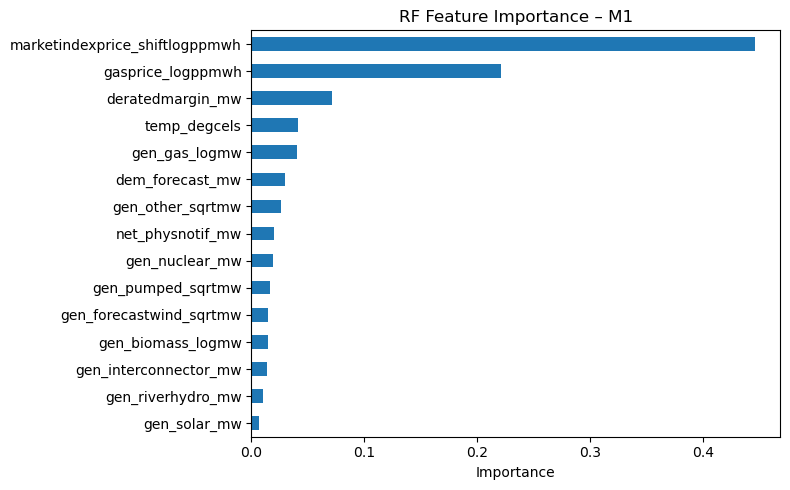

In [ ]:
def plot_feature_importance(importances, title, top_n=15):
    importances.head(top_n).plot(
        kind="barh",
        figsize=(8, 5)
    )
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(imp_M1, "RF Feature Importance – M1")




In [ ]:
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [12, 18, None],
    "min_samples_leaf": [10, 25, 50]
}


In [ ]:
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def rf_hyperparam_sweep(
    train_df,
    test_df,
    target_col,
    price_spike_threshold=150
):
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    results = []

    for n_est, depth, leaf in product(
        param_grid["n_estimators"],
        param_grid["max_depth"],
        param_grid["min_samples_leaf"]
    ):

        rf = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=leaf,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1,
            oob_score=True
        )

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        is_stress = y_test > price_spike_threshold
        stress_mae = mean_absolute_error(
            y_test[is_stress],
            y_pred[is_stress]
        )

        results.append({
            "n_estimators": n_est,
            "max_depth": depth if depth is not None else "None",
            "min_samples_leaf": leaf,
            "MAE": mae,
            "Stress_MAE": stress_mae,
            "R2": r2,
            "OOB_R2": rf.oob_score_
        })

    return pd.DataFrame(results)


In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define the Grid (Ensure this is defined before running the function)
rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [12, 18, None],
    "min_samples_leaf": [10, 25, 50]
}

def rf_hyperparam_sweep(
    train_df,
    test_df,
    target_col,
    param_grid,
    price_spike_threshold=150
):
    # 1. Prepare Data
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    results = []

    # Calculate total combinations for progress tracking
    total_combinations = (
        len(param_grid["n_estimators"]) * len(param_grid["max_depth"]) * len(param_grid["min_samples_leaf"])
    )
    print(f"Starting Random Forest sweep with {total_combinations} combinations...")

    # 2. Loop through parameters
    for n_est, depth, leaf in product(
        param_grid["n_estimators"],
        param_grid["max_depth"],
        param_grid["min_samples_leaf"]
    ):

        # Initialize RF with current params
        rf = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=depth,
            min_samples_leaf=leaf,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1,
            oob_score=True
        )

        # Fit Model
        rf.fit(X_train, y_train)

        # 3. Calculate Training Metrics (To check Overfitting)
        y_train_pred = rf.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        # 4. Calculate Test Metrics
        y_pred = rf.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_r2 = r2_score(y_test, y_pred)

        # 5. Calculate Stress vs. Normal Performance
        is_stress = y_test > price_spike_threshold
        not_stress = y_test <= price_spike_threshold

        # Stress MAE (Prices > 150)
        if is_stress.sum() > 0:
            stress_mae = mean_absolute_error(y_test[is_stress], y_pred[is_stress])
        else:
            stress_mae = np.nan

        # Normal MAE (Prices <= 150)
        if not_stress.sum() > 0:
            not_stress_mae = mean_absolute_error(y_test[not_stress], y_pred[not_stress])
        else:
            not_stress_mae = np.nan

        # 6. Append Results
        results.append({
            "n_estimators": n_est,
            "max_depth": depth if depth is not None else "None",
            "min_samples_leaf": leaf,
            "Train_MAE": train_mae,
            "Test_MAE": test_mae,
            "Train_R2": train_r2,
            "Test_R2": test_r2,
            "OOB_R2": rf.oob_score_,     # Unique to RF
            "Stress_MAE": stress_mae,
            "Not_Stress_MAE": not_stress_mae,
            "Overfit_Gap": train_r2 - test_r2  # Metric to spot overfitting
        })

    # Return DataFrame sorted by Test R2
    return pd.DataFrame(results).sort_values("Test_R2", ascending=False)

In [ ]:
rf_results_M3 = rf_hyperparam_sweep(
    train_M3,
    test_M3,
    target_col="sysprice_ppmwh",
    param_grid=rf_param_grid
)

rf_results_M3.sort_values("Test_MAE").tail()


Starting Random Forest sweep with 18 combinations...


,n_estimators,max_depth,min_samples_leaf,Train_MAE,Test_MAE,Train_R2,Test_R2,OOB_R2,Stress_MAE,Not_Stress_MAE,Overfit_Gap
14,400,18,50,38.453951,23.112176,0.588790,0.402446,0.561078,87.777660,21.420557,0.186344
8,200,None,50,38.498670,23.160432,0.590560,0.405080,0.562596,88.317169,21.455961,0.185480
5,200,18,50,38.554483,23.175545,0.586743,0.402866,0.558458,87.032423,21.505078,0.183877
11,400,12,50,39.077065,23.208479,0.588981,0.405713,0.562618,87.646250,21.522816,0.183268
2,200,12,50,39.122496,23.220774,0.586524,0.397257,0.559490,88.365337,21.516622,0.189267


In [ ]:
rf_results_M3.sort_values("Test_R2").tail(10)

,n_estimators,max_depth,min_samples_leaf,Train_MAE,Test_MAE,Train_R2,Test_R2,OOB_R2,Stress_MAE,Not_Stress_MAE,Overfit_Gap
7,200,None,25,35.728744,22.703230,0.644499,0.475326,0.596277,84.257255,21.093005,0.169172
16,400,None,25,35.657272,22.629828,0.644152,0.475721,0.596177,84.137917,21.020804,0.168431
13,400,18,25,35.771853,22.594187,0.644105,0.478350,0.595247,84.852454,20.965539,0.165754
10,400,12,25,37.521594,22.854404,0.637527,0.479626,0.595650,84.114296,21.251873,0.157901
0,200,12,10,35.499003,22.683936,0.706194,0.509650,0.631635,82.097168,21.129713,0.196543
9,400,12,10,35.495146,22.664133,0.708018,0.524782,0.632537,80.851168,21.141986,0.183236
6,200,None,10,30.301384,22.306974,0.731418,0.528072,0.637699,82.583246,20.730175,0.203346
3,200,18,10,30.980375,22.234338,0.732118,0.538979,0.639679,82.850863,20.648638,0.193139
12,400,18,10,30.986049,22.294090,0.730559,0.541101,0.638424,81.568790,20.743491,0.189457
15,400,None,10,30.269212,22.270521,0.732248,0.547550,0.637441,80.306515,20.752326,0.184697


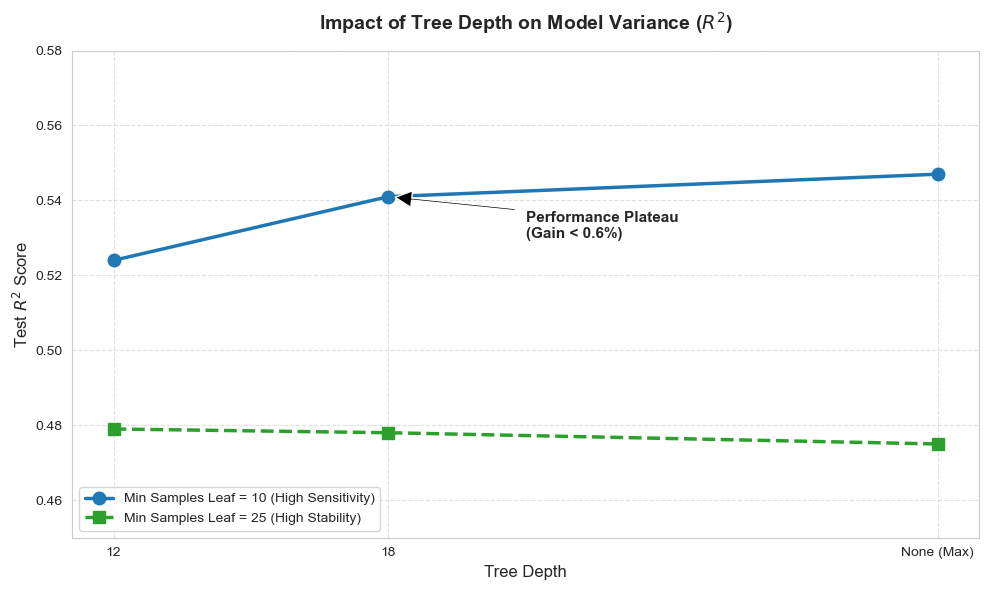

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reconstruct Data (Based on your Grid Search Results)
# We plot two lines to show the consistency of the plateau
data = {
    'max_depth': [12, 18, 30], # Using 30 to represent 'None' for plotting
    'R2_Leaf_10': [0.524, 0.541, 0.547],  # The High Performance Line (Leaf 10)
    'R2_Leaf_25': [0.479, 0.478, 0.475],  # The Stable Line (Leaf 25)
}
df_plot = pd.DataFrame(data)

# 2. Setup Professional Styling
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 3. Plot Line 1: Low Regularization (Leaf 10) - The "Performance" Line
plt.plot(df_plot['max_depth'], df_plot['R2_Leaf_10'],
         marker='o', markersize=9, linewidth=2.5, color='#1f77b4',
         label='Min Samples Leaf = 10 (High Sensitivity)')

# 4. Plot Line 2: High Regularization (Leaf 25) - The "Stable" Line
plt.plot(df_plot['max_depth'], df_plot['R2_Leaf_25'],
         marker='s', markersize=9, linewidth=2.5, color='#2ca02c', linestyle='--',
         label='Min Samples Leaf = 25 (High Stability)')

# 5. Add "Diminishing Returns" Shaded Region
#plt.axvspan(18, 30, color='gray', alpha=0.1, label='Zone of Diminishing Returns')

# 6. Professional Annotations
# Arrow pointing to the specific plateau point
plt.annotate('Performance Plateau\n(Gain < 0.6%)',
             xy=(18, 0.541), xytext=(21, 0.53),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=11, fontweight='bold')

# 7. Formatting
plt.title("Impact of Tree Depth on Model Variance ($R^2$)", fontsize=14, pad=15, fontweight='bold')
plt.ylabel("Test $R^2$ Score", fontsize=12)
plt.xlabel("Tree Depth", fontsize=12)
plt.xticks([12, 18, 30], labels=['12', '18', 'None (Max)'])
plt.ylim(0.45, 0.58) # Zoom in to show the contrast
plt.legend(loc='lower left', frameon=True, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# 8. Show
plt.tight_layout()
plt.show()

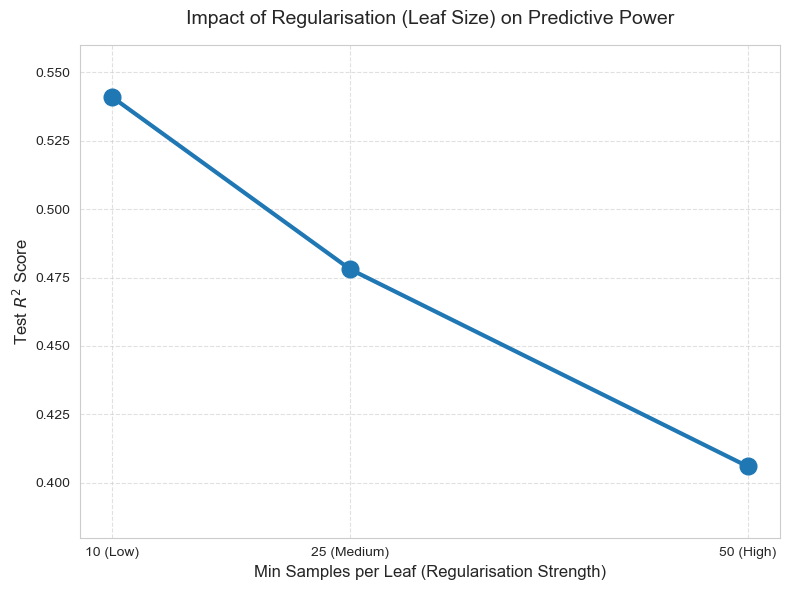

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Prepare Data (Best Case Performance for each Leaf Setting)
data = {
    'min_samples_leaf': [10, 25, 50],
    'Test_R2': [0.541, 0.478, 0.406]  # Performance drops as we constrain the model
}
df_tradeoff = pd.DataFrame(data)

# 2. Setup the Plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# 3. Plot the Line
plt.plot(df_tradeoff['min_samples_leaf'], df_tradeoff['Test_R2'],
         marker='o', markersize=12, linewidth=3, color='#1f77b4', label='Test $R^2$ Score')

# # 4. Add Annotations to tell the story
# # Annotation for the Winner
# plt.annotate('Selected Model (Leaf 10)\nMax Performance ($R^2$=0.54)',
#              xy=(10, 0.541), xytext=(12, 0.53),
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              fontsize=11, fontweight='bold', color='#1f77b4')

# # Annotation for the Loser (Underfitting)
# plt.annotate('Underfitting Zone (Leaf 50)\nModel too constrained ($R^2$=0.41)',
#              xy=(50, 0.406), xytext=(35, 0.42),
#              arrowprops=dict(facecolor='black', shrink=0.05),
#              fontsize=10, color='gray')

# 5. Formatting
plt.title("Impact of Regularisation (Leaf Size) on Predictive Power", fontsize=14, pad=15)
plt.xlabel("Min Samples per Leaf (Regularisation Strength)", fontsize=12)
plt.ylabel("Test $R^2$ Score", fontsize=12)
plt.xticks([10, 25, 50], labels=['10 (Low)', '25 (Medium)', '50 (High)'])
plt.ylim(0.38, 0.56)  # Set limits to frame the data nicely
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

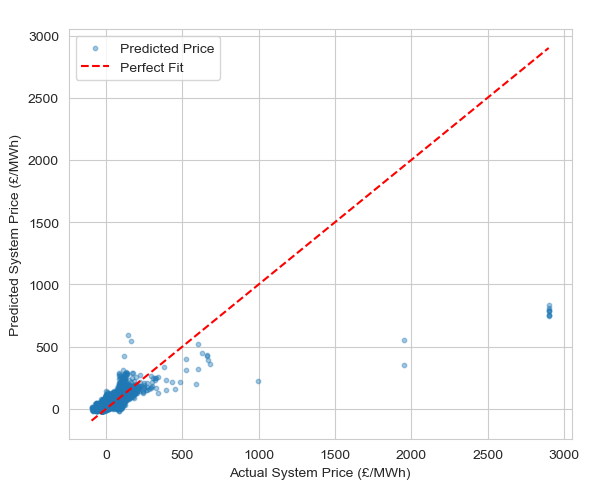

In [ ]:
import matplotlib.pyplot as plt

def plot_predicted_vs_actual(y_true, y_pred, title):
    """
    Scatter plot of Predicted vs Actual values with 45-degree reference line.
    """

    plt.figure(figsize=(6, 5))

    # 1. Add 'label' here so the legend knows what to call the dots
    plt.scatter(y_true, y_pred, alpha=0.4, s=10, label='Predicted Price')

    # 45-degree reference line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())

    # 2. (Optional) Add a label for the red line too
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

    plt.xlabel("Actual System Price (£/MWh)")
    plt.ylabel("Predicted System Price (£/MWh)")
    plt.title(title)
    plt.grid(True)

    # 3. Call legend() to display the labels you added above
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run it
plot_predicted_vs_actual(
    y_test_M3,
    y_pred_M3,  # Ensure this variable matches your actual prediction variable (e.g., y_pred_rf)
    " "
)

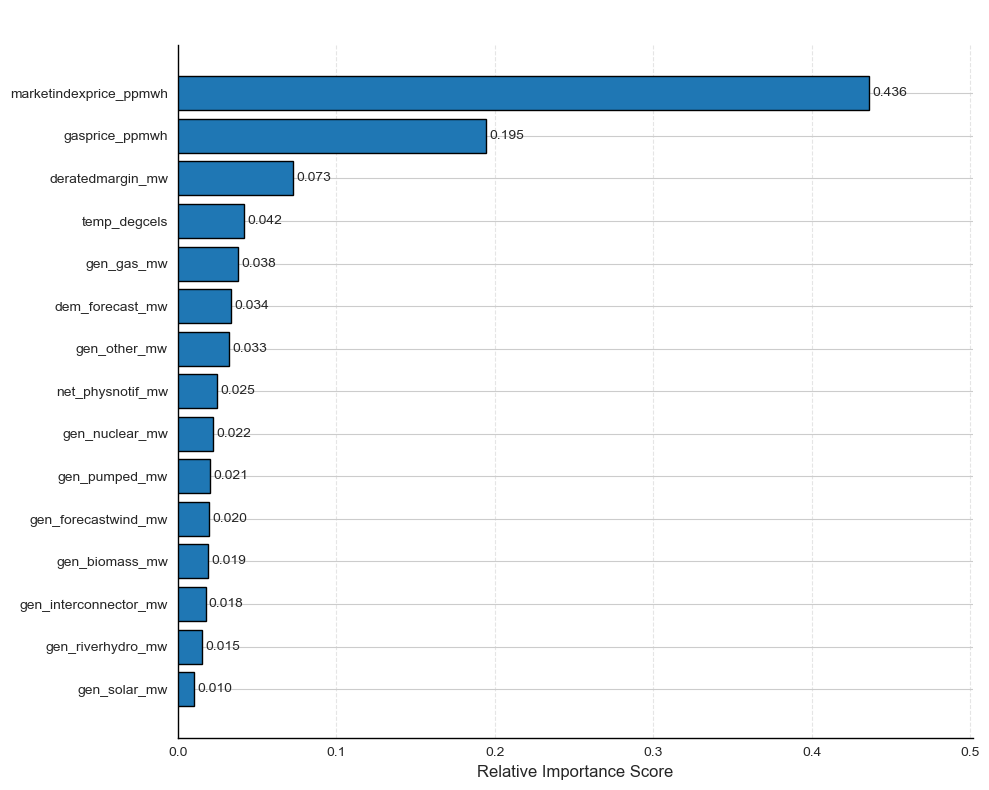

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare Data
df_rf = pd.DataFrame({
    'Feature': X_train_M3.columns,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

# Draw bars with black edges
bars = ax.barh(df_rf['Feature'], df_rf['Importance'],
               color='#1f77b4', edgecolor='black', linewidth=1, zorder=3)

# Add Labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.002, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', va='center', fontsize=10, zorder=4)

# THE FIX: Explicitly set left/bottom spines and hide top/right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1)

# Formatting
ax.grid(visible=True, axis='x', linestyle='--', alpha=0.5, zorder=0)
ax.set_title(" ", fontsize=14, pad=15)
ax.set_xlabel("Relative Importance Score", fontsize=12)
ax.set_xlim(0, max(df_rf['Importance']) * 1.15)

plt.tight_layout()
plt.show()

In [ ]:
#Baseline unoptimised

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# 1. Initialize Baseline Model (Default Hyperparameters)
# We only set random_state for reproducibility and n_jobs for speed
rf_baseline = RandomForestRegressor(
    n_estimators=100,  # Default in sklearn
    max_depth=None,    # Default (Unlimited depth)
    min_samples_leaf=1,# Default (Maximum variance)
    random_state=42,
    n_jobs=-1
)

print("Training Baseline Random Forest (Default Parameters)...")
rf_baseline.fit(X_train_M3, y_train_M3)

# 2. Generate Predictions
y_train_pred_base = rf_baseline.predict(X_train_M3)
y_test_pred_base = rf_baseline.predict(X_test_M3)

# 3. Calculate Metrics
train_mae_base = mean_absolute_error(y_train_M3, y_train_pred_base)
test_mae_base = mean_absolute_error(y_test_M3, y_test_pred_base)
train_r2_base = r2_score(y_train_M3, y_train_pred_base)
test_r2_base = r2_score(y_test_M3, y_test_pred_base)

# 4. Calculate Stress MAE (Prices > 150)
stress_mask = y_test_M3 > 150
if stress_mask.sum() > 0:
    stress_mae_base = mean_absolute_error(y_test_M3[stress_mask], y_test_pred_base[stress_mask])
else:
    stress_mae_base = np.nan

# 5. Print Results
print("\n--- BASELINE RANDOM FOREST PERFORMANCE ---")
print(f"Train MAE:    £{train_mae_base:.2f}")
print(f"Test MAE:     £{test_mae_base:.2f}")
print(f"Stress MAE:   £{stress_mae_base:.2f} (Prices > £150)")
print("-" * 30)
print(f"Train R²:     {train_r2_base:.4f}")
print(f"Test R²:      {test_r2_base:.4f}")
print(f"Overfit Gap:  {train_r2_base - test_r2_base:.4f}")

Training Baseline Random Forest (Default Parameters)...

--- BASELINE RANDOM FOREST PERFORMANCE ---
Train MAE:    £12.68
Test MAE:     £22.14
Stress MAE:   £84.03 (Prices > £150)
------------------------------
Train R²:     0.9551
Test R²:      0.5805
Overfit Gap:  0.3746


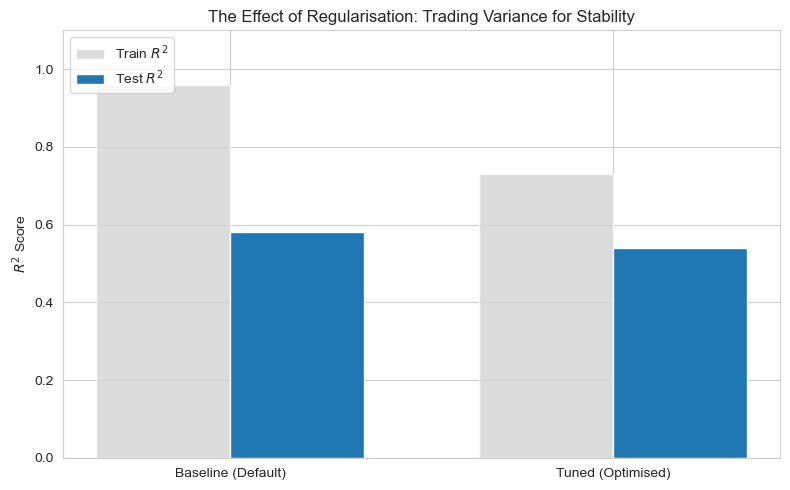

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Baseline (Default)', 'Tuned (Optimised)']
train_r2 = [0.96, 0.73]
test_r2 = [0.58, 0.54]
stress_mae = [84.03, 81.57]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot R2 (grouped bars)
rects1 = ax1.bar(x - width/2, train_r2, width, label='Train $R^2$', color='lightgray', alpha=0.8)
rects2 = ax1.bar(x + width/2, test_r2, width, label='Test $R^2$', color='#1f77b4')

ax1.set_ylabel('$R^2$ Score')
ax1.set_title('The Effect of Regularisation: Trading Variance for Stability')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1.1)
ax1.legend(loc='upper left')

# Add "Gap" arrows
# ax1.annotate('', xy=(0, 0.58), xytext=(0, 0.96),
#              arrowprops=dict(arrowstyle='<->', color='red', lw=2))
# ax1.text(0.05, 0.77, 'Huge Gap\n(0.38)', color='red', fontweight='bold')

# ax1.annotate('', xy=(1, 0.54), xytext=(1, 0.73),
#              arrowprops=dict(arrowstyle='<->', color='green', lw=2))
# ax1.text(1.05, 0.63, 'Stable Gap\n(0.19)', color='green', fontweight='bold')

plt.tight_layout()
plt.show()

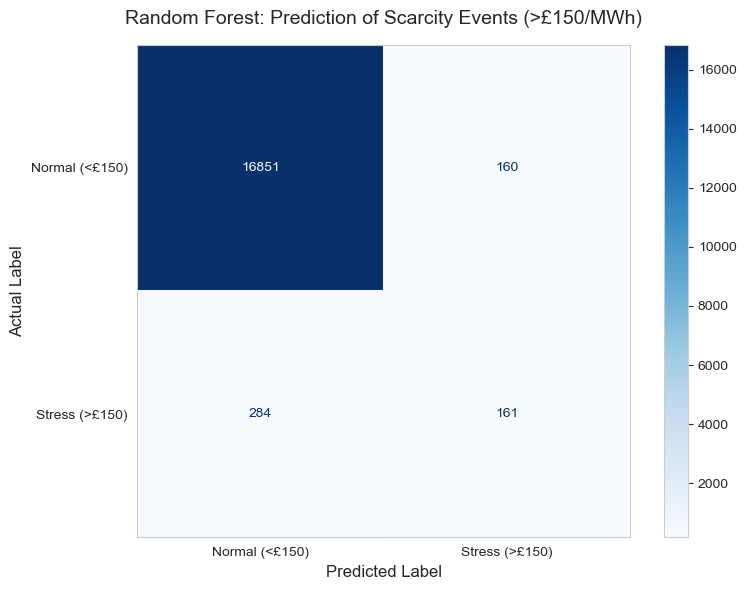

--- Random Forest Classification Performance ---
Threshold: > £150/MWh
Precision: 0.5016 (When it predicts stress, is it right?)
Recall:    0.3618    (Did it catch all the stress events?)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt

# 1. Define the Threshold
threshold = 150

# 2. Create Boolean Vectors (True/False)
# y_test_M3 is the Actual Data
# y_pred_rf is the Random Forest Prediction
stress_actual_bool = y_test_M3 > threshold
stress_pred_bool = y_pred_rf > threshold

# 3. Calculate Confusion Matrix
# Note: sklearn standard is confusion_matrix(y_true, y_pred)
rf_cm = confusion_matrix(stress_actual_bool, stress_pred_bool)

# 4. Plotting
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=rf_cm,
    display_labels=["Normal (<£150)", "Stress (>£150)"]
)

fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap='Blues', values_format='d') # 'd' for integers

# Customise Labels
ax.set_title('Random Forest: Prediction of Scarcity Events (>£150/MWh)', fontsize=14, pad=15)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.grid(False) # Turn off grid for cleaner matrix

plt.tight_layout()
plt.show()

# 5. Print Scores
precision = precision_score(stress_actual_bool, stress_pred_bool)
recall = recall_score(stress_actual_bool, stress_pred_bool)

print("--- Random Forest Classification Performance ---")
print(f"Threshold: > £{threshold}/MWh")
print(f"Precision: {precision:.4f} (When it predicts stress, is it right?)")
print(f"Recall:    {recall:.4f}    (Did it catch all the stress events?)")